<a href="https://colab.research.google.com/github/FrancescaSrc/AIprojects/blob/master/Image_Classification_Project_pytorch_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Challenge final model: Flower Project with densenet 161
For my Pytorch Challenge model I have chosen for the Densenet 161 as feature extractor, looking at the error rate it kind of stood out.
I also made grateful use of Colabs GPU from Google and Kernels form Kaggle. As for code reference, I used these TorchVision and Pytorch tutorials:
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

# Importing and installing the necessary libraries 

In [0]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from collections import OrderedDict
import time
import copy
from PIL import Image

%matplotlib inline

In [0]:
#!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
#!unzip -qq flower_data.zip

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image


In [0]:
from PIL import Image

# The Basic Flower Classifier



The project inclued these steps:

+ Load and preprocess the image dataset
+ Train the image classifier on your dataset
+ Use the trained classifier to predict image content

## Load the data
To prevent overfitting and to give my model more data augmentation to train on, I implemented a series of transformations. I used a random rotation, resizing, addes some jetter and cropping.
The toTensor transformes the image into a ternsor while the Normalize normalize it using the mean and standard deviation calculated on the images. This is necessary because I will use transfer learning to build my model using the pre-trained networks available from torchvision trained on the ImageNet dataset where each color channel was normalized separately. So I need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1. The input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.




In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
batch_size=8
num_workers=0

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.ColorJitter(hue=.08, saturation=.08),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/My Drive/Colab Notebooks/flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Label mapping
A mapping from category label to category name is done using the file cat_to_name.json. It's a JSON object which you can read in with the json module. This gives a dictionary mapping the integer encoded categories to the actual names of the flowers which will be assigned to the new trained network in order to produce the predictions according to the right mapping.

As I learned from the [source code of torchvision.datasets.folder](https://pytorch.org/docs/0.4.0/_modules/torchvision/datasets/folder.html), each datasetFolder has the following attributes: 

       + classes (list): List of the class names.
       + class_to_idx (dict): Dict with items (class_name, class_index).
       + samples (list): List of (sample path, class_index) tuples


In [0]:
import json
with open('drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
#cat_to_name = {int(n):cat_to_name[n] for n in cat_to_name}
#sorted_keys = sorted(cat_to_name.keys())
classes=[]
for i in image_datasets['train'].classes:
    classes.append(cat_to_name[i])


In [0]:
import json
with open('drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    label_map = json.load(f)

Train the data on GPU

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
print(torch.cuda.is_available())
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    


True
CUDA is available!  Training on GPU ...


**TRAIN FUNCTION**

This is my train model function for the train and validation step. 

Autograd is a function in Pytorch, every tensor has a flag requires_grad for gradient computation purposes.
**Requires_grad = False** is the default

Requires_grad is used to freeze a part of a model or to finetune a pretrained CNN with
param.requires_grad=False
So the gradient will be calculated only in the last layer.

In this code I unfreeze the network and train it all after 15 epochs.

I added a saving function to the original code which saves the checkpoint if the loss decreases and adds the right attributes to the checkpoint in order to be able to retrain the checkpoind after the first try.


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        """if epoch > 20:
            for param in model_ft.parameters():
              param.requires_grad = True"""
            
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                print('Accuracy increased ({:.6f} --> {:.6f}).  Saving model checkpoint12feb ...'.format(best_acc, epoch_acc))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save model if loss has decreased
                model.cpu()
                torch.save({'epoch': epoch + 1,
                                 'state_dict': model.state_dict(),
                                 'optimizer' : optimizer.state_dict(),
                                 'model': 'densenet161',
                                 'loss': loss,
                                 'class_to_idx': model_ft.class_to_idx},
                                 'drive/My Drive/Colab Notebooks/checkpoint12feb.pth'
                                )
                model.cuda()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Loading the pretrained network

In [0]:

model_ft = models.densenet161(pretrained=True)
model_ft.classifier
model_ft.class_to_idx = image_datasets['train'].class_to_idx



/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
115730790it [00:02, 43333615.32it/s]


I tried different optimizers and loss functions but hte best combination seemde to be the Adam + NNLoss. I added a sheduler to decrease the learning rate every 20 epochs.
I decrease the batchsize to 8.
After some tests:
Adam for classifier.parameters, lr 0.001, sheduler StepLR step 30, batch size 8,  40 epochs
Note: saving to checkpoint20dec.pth
First batch is already 0,92

In [0]:

n_inputs = 2208
# Freeze parameters so we don't backprop through them

for i in range(len(model_ft.features)-3):
  model_ft.features[i].requires_grad = False

for i in range(9,12):
    model_ft.features[i].requires_grad=True
    

"""ct = 0
for child in model_ft.children():
  ct += 1
  if ct < 10:
    for param in child.parameters():
        param.requires_grad = False"""

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.4)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model_ft.classifier = classifier
model_ft = model_ft.to(device)

# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
#try with
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)






The network is delivering good results, 0.982885 is not bad at all.

In [0]:

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0537 Acc: 0.9853
valid Loss: 0.0909 Acc: 0.9792
Accuracy increased (0.000000 --> 0.979218).  Saving model checkpoint12feb ...

Epoch 1/29
----------
train Loss: 0.0519 Acc: 0.9856
valid Loss: 0.0883 Acc: 0.9792

Epoch 2/29
----------
train Loss: 0.0509 Acc: 0.9859
valid Loss: 0.0921 Acc: 0.9780

Epoch 3/29
----------
train Loss: 0.0483 Acc: 0.9871
valid Loss: 0.0855 Acc: 0.9792

Epoch 4/29
----------
train Loss: 0.0475 Acc: 0.9883
valid Loss: 0.0895 Acc: 0.9804
Accuracy increased (0.979218 --> 0.980440).  Saving model checkpoint12feb ...

Epoch 5/29
----------
train Loss: 0.0497 Acc: 0.9860
valid Loss: 0.0922 Acc: 0.9792

Epoch 6/29
----------
train Loss: 0.0559 Acc: 0.9825
valid Loss: 0.0896 Acc: 0.9792

Epoch 7/29
----------
train Loss: 0.0463 Acc: 0.9886
valid Loss: 0.0878 Acc: 0.9817
Accuracy increased (0.980440 --> 0.981663).  Saving model checkpoint12feb ...

Epoch 8/29
----------
train Loss: 0.0456 Acc: 0.9886
valid Loss: 0.0937 Acc: 0.9792

E

### Saving the model and adding the class_to_idx file

In [0]:
model_ft.class_to_idx = image_datasets['train'].class_to_idx
model_ft.cpu()
torch.save({'model': 'densenet161',
            'state_dict': model_ft.state_dict(), 
            'class_to_idx': model_ft.class_to_idx}, 
            'drive/My Drive/Colab Notebooks/model12feb.pth')

# loading the model

In [0]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['model'] == 'densenet161':
        model = models.densenet161(pretrained=False)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
      
    
    model.class_to_idx = chpt['class_to_idx']
    from collections import OrderedDict
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.4)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

## Testing the results

In [0]:
model3 = load_model('drive/My Drive/Colab Notebooks/checkpoint12feb.pth')
model3.cuda()
state_dict=model3.state_dict()

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


### Creating functions to visualize the model

In [0]:
def imshow1(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
   

In [0]:
def visualize_model(model, num_images=6):
    model.cuda()
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            print(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            print(inputs.size()[0])
            
            
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far) #subplot(nrows, ncols, index, **kwargs)
                #ax = plt.subplot(num_images//2, 2, j+1, xticks=[], yticks=[])
                ax.axis('off')
                ax.set_title('{}'.format(classes[preds[j]]) + ' ({})'.format(classes[labels[j]]), color=("green" if preds[j]==labels[j] else "red"))
               
                imshow1(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([12, 95, 51, 48, 21, 73, 43, 72], device='cuda:0')
8


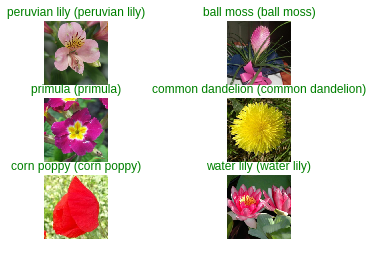

In [0]:
visualize_model(model3)

## Verifying Accuracy

In [0]:
def calc_accuracy(model, data):
    model.eval()
    model.to(device)    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data):
            inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print("predicted flower type", predicted) #the predicted class
                print("how sure is model", torch.exp(_)) # the predicted probability
            equals = predicted == labels.data
            if idx == 0:
                print("correct or not", equals)
            print("accuracy for each batch", equals.float().mean())

In [0]:
#12feb
calc_accuracy(model3, dataloaders['valid'])

predicted flower type tensor([77, 17, 40, 85,  5, 33, 18, 83], device='cuda:0')
how sure is model tensor([1.0000, 1.0000, 1.0000, 0.9999, 0.9990, 1.0000, 1.0000, 0.9994],
       device='cuda:0')
correct or not tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(0.8750, device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device

### Calculating loss

In [0]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model_ft.eval() # eval mode

# iterate over test data
for data, target in dataloaders['valid']:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
       data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model3(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(dataloaders['valid'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))



Test Loss: 0.079552



In [0]:
for i in range(102):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        #print(100 * class_correct[i] / class_total[i])

             
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of pink primrose: 100% ( 8/ 8)
Test Accuracy of globe thistle: 100% ( 4/ 4)
Test Accuracy of blanket flower: 100% ( 6/ 6)
Test Accuracy of trumpet creeper: 100% ( 5/ 5)
Test Accuracy of blackberry lily: 100% ( 6/ 6)
Test Accuracy of snapdragon: 100% (10/10)
Test Accuracy of colt's foot: 100% ( 5/ 5)
Test Accuracy of king protea: 100% ( 5/ 5)
Test Accuracy of spear thistle: 100% ( 1/ 1)
Test Accuracy of yellow iris: 100% ( 7/ 7)
Test Accuracy of globe-flower: 100% ( 2/ 2)
Test Accuracy of purple coneflower: 100% (16/16)
Test Accuracy of peruvian lily: 100% (11/11)
Test Accuracy of balloon flower: 100% ( 4/ 4)
Test Accuracy of hard-leaved pocket orchid: 100% ( 6/ 6)
Test Accuracy of giant white arum lily: 85% ( 6/ 7)
Test Accuracy of fire lily: 100% ( 4/ 4)
Test Accuracy of pincushion flower: 100% ( 8/ 8)
Test Accuracy of fritillary: 100% (12/12)
Test Accuracy of red ginger: 100% ( 5/ 5)
Test Accuracy of grape hyacinth: 100% ( 2/ 2)
Test Accuracy of corn poppy: 100% ( 3/ 3)

In [0]:
for i in range(102):        
        if 100 * class_correct[i] / class_total[i] < 100:
            print('Test Accuracy non accurate of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

Test Accuracy non accurate of giant white arum lily: 85% ( 6/ 7)
Test Accuracy non accurate of canterbury bells: 50% ( 1/ 2)
Test Accuracy non accurate of sweet william: 90% ( 9/10)
Test Accuracy non accurate of bolero deep blue: 75% ( 3/ 4)
Test Accuracy non accurate of wild pansy: 90% ( 9/10)
Test Accuracy non accurate of sunflower: 90% ( 9/10)
Test Accuracy non accurate of japanese anemone: 66% ( 2/ 3)
Test Accuracy non accurate of moon orchid:  0% ( 0/ 1)
Test Accuracy non accurate of morning glory: 95% (19/20)
Test Accuracy non accurate of ball moss: 83% ( 5/ 6)
Test Accuracy non accurate of foxglove: 92% (13/14)
Test Accuracy non accurate of camellia: 90% ( 9/10)


In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 226))
    else:
        img.thumbnail((226, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Making predictions

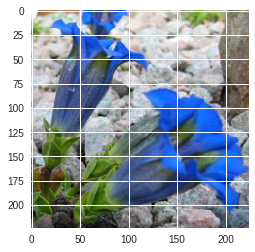

In [0]:
image_path = 'drive/My Drive/Colab Notebooks/flower_data/valid/28/image_05272.jpg'
img = process_image(image_path)
imshow(img)

In [0]:
# Process image
img = process_image(image_path) 
img = torch.from_numpy(img).type(torch.cuda.FloatTensor) 
img.unsqueeze_(0)
# Predict top 5
#moved loaded model to gpu
probs = torch.exp(model3.cuda().forward(img)) 
top_probs, top_labs = probs.topk(5)
top_probs.cpu()
top_labs.cpu()

tensor([[23, 91, 29, 20, 13]])

In [0]:
top_probs = top_probs.detach().cpu().numpy().tolist()[0]
top_labs = top_labs.detach().cpu().numpy().tolist()[0]

In [0]:
idx_to_class = {val: key for key, val in model3.class_to_idx.items()}
print(idx_to_class)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

In [0]:
top_labels = [idx_to_class[lab] for lab in top_labs]

In [0]:
top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]

## Class Prediction
Once you can get images in the correct format, you need a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top- 𝐾 ) most probable classes. You'll want to calculate the class probabilities then find the  𝐾  largest values.

To get the top  𝐾  largest values in a tensor use x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using class_to_idx which hopefully you added to the model or from an ImageFolder you used to load the data (see here). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

+ probs, classes = predict(image_path, model)
+ print(probs)
+ print(classes)
+ [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
+ ['70', '3', '45', '62', '55']

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
import seaborn as sns
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[5]
    print(flower_num)
    title_ = label_map[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model.cpu()) 
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Sanity Checking
With matplotlib, plot the probabilities for the top 5 classes as a bar graph, along with the input image and use the imshow to show a PyTorch tensor as an image.

39


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


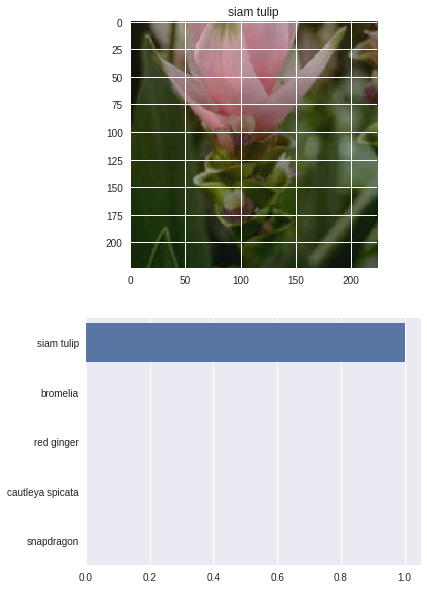

In [0]:
image_path = "drive/My Drive/Colab Notebooks/flower_data/valid/39/image_07013.jpg"
plot_solution(image_path, model3)

10


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


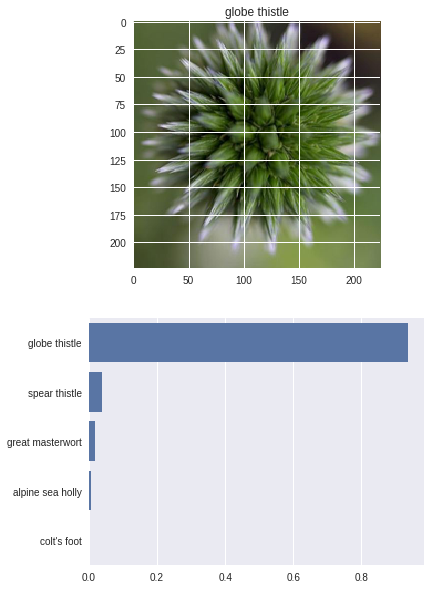

In [0]:
image_path = "drive/My Drive/Colab Notebooks/flower_data/valid/10/image_07101.jpg"
plot_solution(image_path, model3)

7


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


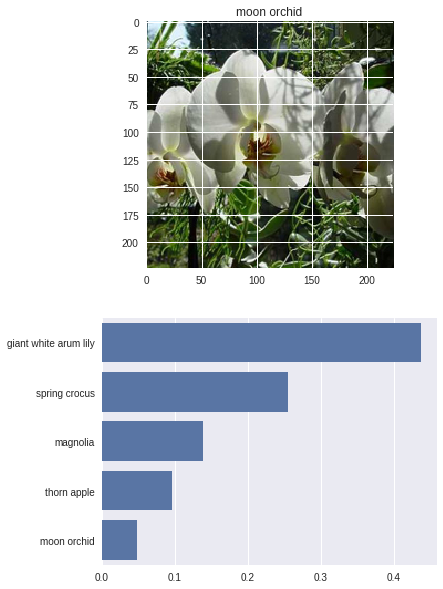

In [0]:
image_path = "drive/My Drive/Colab Notebooks/flower_data/valid/7/image_07216.jpg"
plot_solution(image_path, model3)

4


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


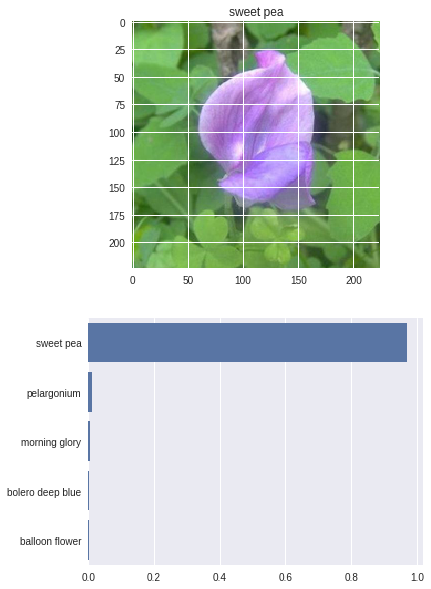

In [0]:
image_path = "drive/My Drive/Colab Notebooks/flower_data/valid/4/image_05660.jpg"
plot_solution(image_path, model3)

20


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


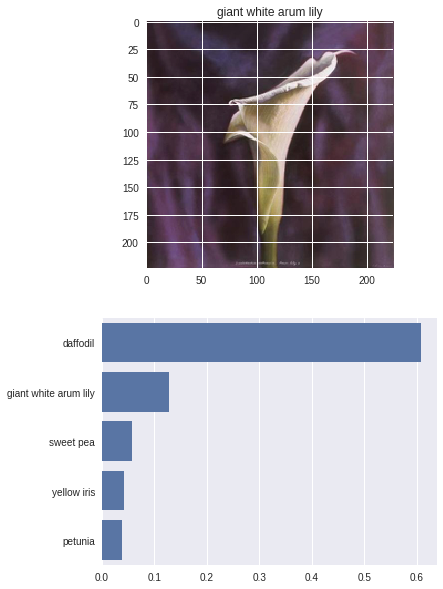

In [0]:
image_path = "drive/My Drive/Colab Notebooks/flower_data/valid/20/image_04927.jpg"
plot_solution(image_path, model3)


36


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


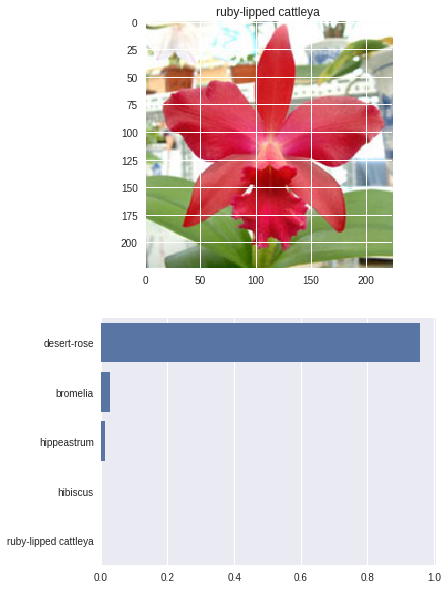

In [0]:
image_path = "drive/My Drive/Colab Notebooks/flower_data/valid/36/image_04333.jpg"
plot_solution(image_path, model3)

53


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


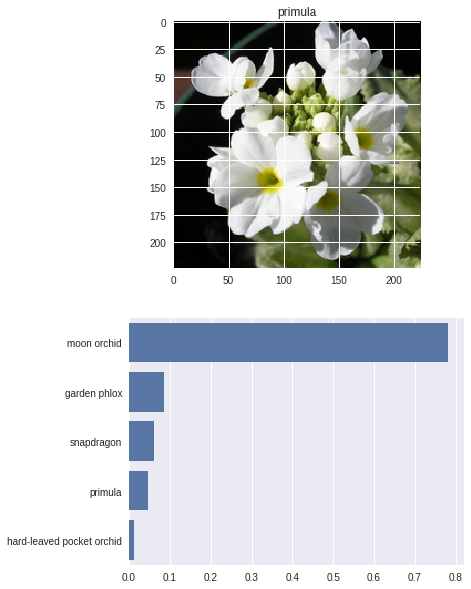

In [0]:
image_path = "drive/My Drive/Colab Notebooks/flower_data/valid/53/image_03693.jpg"
plot_solution(image_path, model3)

In [0]:
def load_checkpoint(model, optimizer, filename='0.988998checkpoint22dec2.pth'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        state_dict=model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss = checkpoint['loss']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, loss, state_dict

In [0]:
def retrain_model(model, criterion, optimizer, scheduler, state_dict, loss, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        if epoch == 20:
            for param in model_ft.parameters():
                param.requires_grad = True
            
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                print('Accuracy increased ({:.6f} --> {:.6f}).  Saving model checkpoint28dec ...'.format(best_acc, epoch_acc))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save model if loss has decreased   
                torch.save({'epoch': epoch + 1,
                                 'state_dict': model.state_dict(),
                                 'optimizer' : optimizer.state_dict(),
                                 'model': 'densenet161',
                                 'loss': loss, 
                                 'class_to_idx': model_ft.class_to_idx},
                                 'drive/My Drive/Colab Notebooks/098288checkpoint28dec_retrained2.pth'
                                )
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
n_inputs = 2208
# Freeze parameters so we don't backprop through them
for param in model_ft.parameters():
    param.requires_grad = True

"""ct = 0
for child in model_ft.children():
  ct += 1
  if ct < 10:
    for param in child.parameters():
        param.requires_grad = False"""

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.4)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model_ft.classifier = classifier
model_ft = model_ft.to(device)

# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
#try with
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
#optimizer_ft = optim.SGD(model_ft.classifier.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [0]:

checkpoint, optimizer, start_epoch, loss, state_dict = load_checkpoint(model3, optimizer_ft, 'drive/My Drive/Colab Notebooks/checkpoint28dec.pth')
checkpoint.cuda()

In [0]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
retrain_model(checkpoint, criterion, optimizer, exp_lr_scheduler, state_dict, loss, num_epochs=9)

In [0]:
#098288checkpoint28dec_retrained 2x

checkpoint, optimizer, start_epoch, loss, state_dict = load_checkpoint(model3, optimizer_ft, 'drive/My Drive/Colab Notebooks/098288checkpoint28dec_retrained.pth')
checkpoint.cuda()


In [0]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
retrain_model(checkpoint, criterion, optimizer, exp_lr_scheduler, state_dict, loss, num_epochs=17)

Epoch 0/16
----------
train Loss: 0.0402 Acc: 0.9845
valid Loss: 0.1048 Acc: 0.9817
Accuracy increased (0.000000 --> 0.981663).  Saving model checkpoint28dec ...

Epoch 1/16
----------
train Loss: 0.0361 Acc: 0.9845
valid Loss: 0.1104 Acc: 0.9817

Epoch 2/16
----------
train Loss: 0.0364 Acc: 0.9851
valid Loss: 0.1063 Acc: 0.9829
Accuracy increased (0.981663 --> 0.982885).  Saving model checkpoint28dec ...

Epoch 3/16
----------
train Loss: 0.0385 Acc: 0.9848
valid Loss: 0.1108 Acc: 0.9804

Epoch 4/16
----------
train Loss: 0.0332 Acc: 0.9857
valid Loss: 0.1110 Acc: 0.9817

Epoch 5/16
----------
train Loss: 0.0357 Acc: 0.9872
valid Loss: 0.1119 Acc: 0.9829

Epoch 6/16
----------
train Loss: 0.0368 Acc: 0.9853
valid Loss: 0.1135 Acc: 0.9804

Epoch 7/16
----------
train Loss: 0.0333 Acc: 0.9859
valid Loss: 0.1109 Acc: 0.9817

Epoch 8/16
----------
train Loss: 0.0365 Acc: 0.9859
valid Loss: 0.1122 Acc: 0.9829

Epoch 9/16
----------
train Loss: 0.0359 Acc: 0.9845
valid Loss: 0.1079 Acc: 0.

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
torch.save({'model': 'densenet161',
            'state_dict': checkpoint.state_dict(), 
            'class_to_idx': model_ft.class_to_idx}, 
            'drive/My Drive/Colab Notebooks/098288classifier28dec_retrained2.pth')